In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [2]:
#Data Analysis and preprocessing
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [3]:
#lets now create a function to status for a batch
def batch_status(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id not found,possible batch id: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

In [4]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])



Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 2:
Image - Min Value: 2 Max Value: 204
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


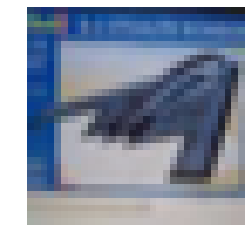

In [5]:
#Exploring the data 
batch_status(cifar10_dataset_folder_path, 4, 2)


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 60:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 5 Name: dog


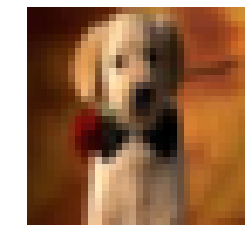

In [6]:
batch_status(cifar10_dataset_folder_path, 2, 60)

In [7]:
#apply normalisation and OHE to data set
def normalize(image):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(image.astype(float))        
    
    #print(normalized_images[0])# The first images index is number of images
    #print(normalized_images[1]) # hieight, width and depth of the image    
    
    num_images = image.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = image.max(), image.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (image[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

In [8]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    return one_hot_encoded_targets.toarray()


In [9]:
# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

C:\Users\shurastogi\AppData\Local\Continuum\anaconda3\envs\tensor\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\shurastogi\AppData\Local\Continuum\anaconda3\envs\tensor\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\shurastogi\AppData\Local\Continuum\anaconda3\envs\tensor\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_value

In [10]:
# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [11]:

# Defining the model inputs
import tensorflow as tf
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

In [12]:

# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [13]:
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

In [14]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

In [15]:
#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [16]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits


In [17]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [18]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
test_conv_net(build_convolution_net)

Neural Network Built!


In [20]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

In [21]:

#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [22]:
# Model Hyperparameters
num_epochs = 50
batch_size = 128
keep_probability = 0.5

In [23]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [24]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1777.864136
Valid accuracy: 0.132812
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1441.311279
Valid accuracy: 0.078125
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1150.654297
Valid accuracy: 0.070312
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1167.920898
Valid accuracy: 0.117188
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1089.361816
Valid accuracy: 0.132812
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 968.778748
Valid accuracy: 0.117188
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 998.894348
Valid accuracy: 0.085938
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 748.041992
Valid accuracy: 0.140625
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 698.837158
Valid accuracy: 0.109375
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 582.980469
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Nu

Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 198.586090
Valid accuracy: 0.304688
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 182.556992
Valid accuracy: 0.312500
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 189.624756
Valid accuracy: 0.328125
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 157.125092
Valid accuracy: 0.359375
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 199.520996
Valid accuracy: 0.296875
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 185.544189
Valid accuracy: 0.296875
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 195.801117
Valid accuracy: 0.367188
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 189.006439
Valid accuracy: 0.304688
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 173.996338
Valid accuracy: 0.320312
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 219.736938
Valid accuracy: 0.296875
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 164.186096
Valid accuracy: 0.382812
Epoch numb

Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 132.619217
Valid accuracy: 0.257812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 118.943230
Valid accuracy: 0.382812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 134.876862
Valid accuracy: 0.328125
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 113.369217
Valid accuracy: 0.468750
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 94.096283
Valid accuracy: 0.421875
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 90.381104
Valid accuracy: 0.351562
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 119.324783
Valid accuracy: 0.382812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 104.211945
Valid accuracy: 0.328125
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 96.403130
Valid accuracy: 0.367188
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 107.773804
Valid accuracy: 0.359375
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 93.943985
Valid accuracy: 0.359375
Epoch number  

Valid accuracy: 0.414062
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 71.436691
Valid accuracy: 0.406250
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 86.748314
Valid accuracy: 0.328125
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 72.573364
Valid accuracy: 0.375000
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 67.650894
Valid accuracy: 0.421875
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 75.364532
Valid accuracy: 0.414062
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 62.393230
Valid accuracy: 0.414062
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 60.599594
Valid accuracy: 0.421875
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 71.459038
Valid accuracy: 0.414062
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 71.786240
Valid accuracy: 0.390625
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 77.948212
Valid accuracy: 0.351562
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 78.162636
Valid accuracy: 0.325

Valid accuracy: 0.398438
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 44.263344
Valid accuracy: 0.421875
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 46.982258
Valid accuracy: 0.500000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 41.754128
Valid accuracy: 0.500000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 37.181625
Valid accuracy: 0.445312
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 37.510101
Valid accuracy: 0.500000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 52.417511
Valid accuracy: 0.414062
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 46.706230
Valid accuracy: 0.500000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 47.776649
Valid accuracy: 0.382812
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 40.095169
Valid accuracy: 0.390625
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 46.492599
Valid accuracy: 0.414062
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 45.316288
Valid accuracy: 0.375

Valid accuracy: 0.359375
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 43.967827
Valid accuracy: 0.398438
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 37.277344
Valid accuracy: 0.421875
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 35.545448
Valid accuracy: 0.414062
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 32.056900
Valid accuracy: 0.437500
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 34.962139
Valid accuracy: 0.445312
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 33.050167
Valid accuracy: 0.468750
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 37.288204
Valid accuracy: 0.414062
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 44.425781
Valid accuracy: 0.421875
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 47.170185
Valid accuracy: 0.359375
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 31.557192
Valid accuracy: 0.468750
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 42.548992
Valid accuracy: 0.414

Valid accuracy: 0.414062
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 21.090588
Valid accuracy: 0.476562
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 27.153580
Valid accuracy: 0.382812
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 17.500854
Valid accuracy: 0.500000
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 23.157358
Valid accuracy: 0.421875
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 20.900330
Valid accuracy: 0.507812
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 25.662615
Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 24.667843
Valid accuracy: 0.421875
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 25.446743
Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 22.470694
Valid accuracy: 0.460938
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 29.296894
Valid accuracy: 0.421875
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 28.109699
Valid accuracy: 0.468

Valid accuracy: 0.539062
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 18.721169
Valid accuracy: 0.500000
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 21.604362
Valid accuracy: 0.406250
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 17.864763
Valid accuracy: 0.476562
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 20.049894
Valid accuracy: 0.382812
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 24.713928
Valid accuracy: 0.398438
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 14.279894
Valid accuracy: 0.515625
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 16.845434
Valid accuracy: 0.484375
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 17.169289
Valid accuracy: 0.507812
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 17.119934
Valid accuracy: 0.460938
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 17.843727
Valid accuracy: 0.492188
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 17.246630
Valid accuracy: 0.492

Valid accuracy: 0.546875
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 16.497646
Valid accuracy: 0.453125
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 13.372880
Valid accuracy: 0.468750
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 16.746727
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.439903
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 13.915151
Valid accuracy: 0.468750
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 17.527945
Valid accuracy: 0.468750
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 12.450833
Valid accuracy: 0.507812
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 15.999580
Valid accuracy: 0.421875
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 16.965549
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 13.902040
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 15.160735
Valid accuracy: 0.460

Valid accuracy: 0.445312
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 7.556282
Valid accuracy: 0.515625
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.068473
Valid accuracy: 0.500000
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 10.117890
Valid accuracy: 0.484375
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 8.940752
Valid accuracy: 0.484375
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 9.505583
Valid accuracy: 0.460938
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 9.743429
Valid accuracy: 0.453125
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 10.371761
Valid accuracy: 0.468750
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.870102
Valid accuracy: 0.398438
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 8.866355
Valid accuracy: 0.484375
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 12.769066
Valid accuracy: 0.343750
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 7.256923
Valid accuracy: 0.515625
Ep

Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 6.684496
Valid accuracy: 0.476562
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 8.271208
Valid accuracy: 0.421875
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 7.473517
Valid accuracy: 0.468750
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 7.871119
Valid accuracy: 0.390625
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 8.771505
Valid accuracy: 0.390625
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 7.749705
Valid accuracy: 0.425000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 6.173379
Valid accuracy: 0.539062
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 5.446449
Valid accuracy: 0.554688
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 7.885493
Valid accuracy: 0.453125
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 8.380415
Valid accuracy: 0.421875
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 7.927969
Valid accuracy: 0.437500
Epoch number 14, CIFAR-10 Batch 

Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 5.581974
Valid accuracy: 0.492188
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 5.303127
Valid accuracy: 0.445312
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 5.352180
Valid accuracy: 0.453125
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 5.126542
Valid accuracy: 0.453125
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 4.705878
Valid accuracy: 0.460938
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 5.058908
Valid accuracy: 0.445312
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 3.726768
Valid accuracy: 0.515625
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 5.583673
Valid accuracy: 0.421875
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 4.606373
Valid accuracy: 0.453125
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.627016
Valid accuracy: 0.476562
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.649779
Valid accuracy: 0.445312
Epoch number 15, CIFAR-10 Batch 

Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.136154
Valid accuracy: 0.445312
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 3.668202
Valid accuracy: 0.414062
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 3.902761
Valid accuracy: 0.468750
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 3.801493
Valid accuracy: 0.476562
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 3.998549
Valid accuracy: 0.398438
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 2.722941
Valid accuracy: 0.476562
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 2.523860
Valid accuracy: 0.484375
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 3.337024
Valid accuracy: 0.468750
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 2.831290
Valid accuracy: 0.468750
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 2.714135
Valid accuracy: 0.460938
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 2.996840
Valid accuracy: 0.484375
Epoch number 16, CIFAR-10 Batch 

Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 1.922087
Valid accuracy: 0.367188
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.793394
Valid accuracy: 0.351562
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.851573
Valid accuracy: 0.421875
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.120725
Valid accuracy: 0.414062
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.428161
Valid accuracy: 0.328125
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.219838
Valid accuracy: 0.414062
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.692732
Valid accuracy: 0.390625
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.091937
Valid accuracy: 0.445312
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.659225
Valid accuracy: 0.390625
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.949137
Valid accuracy: 0.335938
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 2.700078
Valid accuracy: 0.350000
Epoch number 18, CIFAR-10 Batch 

Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.780914
Valid accuracy: 0.375000
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.555373
Valid accuracy: 0.468750
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.643676
Valid accuracy: 0.367188
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.509282
Valid accuracy: 0.484375
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.006793
Valid accuracy: 0.429688
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.603998
Valid accuracy: 0.437500
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.676011
Valid accuracy: 0.375000
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.679086
Valid accuracy: 0.468750
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.752472
Valid accuracy: 0.351562
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.628790
Valid accuracy: 0.382812
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.713722
Valid accuracy: 0.390625
Epoch number 19, CIFAR-10 Batch 

Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.686532
Valid accuracy: 0.367188
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.650191
Valid accuracy: 0.406250
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.741981
Valid accuracy: 0.359375
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.696353
Valid accuracy: 0.460938
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.631028
Valid accuracy: 0.429688
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.764282
Valid accuracy: 0.390625
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.736438
Valid accuracy: 0.335938
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.774266
Valid accuracy: 0.375000
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.735919
Valid accuracy: 0.398438
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.659513
Valid accuracy: 0.437500
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 1.697972
Valid accuracy: 0.367188
Epoch number 20, CIFAR-10 Batch 

Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.644307
Valid accuracy: 0.421875
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.654839
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.728431
Valid accuracy: 0.367188
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.692296
Valid accuracy: 0.414062
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.724899
Valid accuracy: 0.390625
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.633888
Valid accuracy: 0.406250
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.759418
Valid accuracy: 0.375000
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.688514
Valid accuracy: 0.375000
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.600096
Valid accuracy: 0.421875
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.662463
Valid accuracy: 0.351562
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.667043
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch 

Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.724882
Valid accuracy: 0.382812
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.612397
Valid accuracy: 0.398438
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.568767
Valid accuracy: 0.476562
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.675587
Valid accuracy: 0.351562
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.649568
Valid accuracy: 0.460938
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.698934
Valid accuracy: 0.445312
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.639606
Valid accuracy: 0.421875
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.641711
Valid accuracy: 0.476562
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.631775
Valid accuracy: 0.460938
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.738492
Valid accuracy: 0.375000
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.634389
Valid accuracy: 0.437500
Epoch number 23, CIFAR-10 Batch 

Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.700894
Valid accuracy: 0.429688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.590606
Valid accuracy: 0.382812
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.719979
Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.724667
Valid accuracy: 0.328125
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.723102
Valid accuracy: 0.406250
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.684885
Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.627968
Valid accuracy: 0.406250
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.730695
Valid accuracy: 0.328125
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.679848
Valid accuracy: 0.429688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.654504
Valid accuracy: 0.421875
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.736986
Valid accuracy: 0.375000
Epoch number 24, CIFAR-10 Batch 

Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.644635
Valid accuracy: 0.382812
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.700997
Valid accuracy: 0.320312
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.667058
Valid accuracy: 0.351562
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.753278
Valid accuracy: 0.343750
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.592335
Valid accuracy: 0.429688
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.649235
Valid accuracy: 0.382812
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.626056
Valid accuracy: 0.398438
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.651350
Valid accuracy: 0.406250
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.656138
Valid accuracy: 0.398438
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.706828
Valid accuracy: 0.375000
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.623682
Valid accuracy: 0.398438
Epoch number 25, CIFAR-10 Batch 

Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.620696
Valid accuracy: 0.390625
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.623119
Valid accuracy: 0.429688
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.707922
Valid accuracy: 0.421875
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.715805
Valid accuracy: 0.414062
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.730975
Valid accuracy: 0.312500
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.668956
Valid accuracy: 0.398438
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.548051
Valid accuracy: 0.421875
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.563917
Valid accuracy: 0.460938
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.561531
Valid accuracy: 0.453125
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.674183
Valid accuracy: 0.351562
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.650052
Valid accuracy: 0.429688
Epoch number 27, CIFAR-10 Batch 

Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.675669
Valid accuracy: 0.367188
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.643417
Valid accuracy: 0.421875
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.671957
Valid accuracy: 0.406250
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.791049
Valid accuracy: 0.351562
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.660454
Valid accuracy: 0.367188
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.668238
Valid accuracy: 0.476562
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.573495
Valid accuracy: 0.367188
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.732141
Valid accuracy: 0.390625
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.695446
Valid accuracy: 0.367188
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.747317
Valid accuracy: 0.343750
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.667075
Valid accuracy: 0.406250
Epoch number 28, CIFAR-10 Batch 

Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.662202
Valid accuracy: 0.421875
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.599237
Valid accuracy: 0.398438
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.551550
Valid accuracy: 0.437500
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.601927
Valid accuracy: 0.445312
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.627320
Valid accuracy: 0.320312
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.659822
Valid accuracy: 0.390625
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.714603
Valid accuracy: 0.375000
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.643330
Valid accuracy: 0.281250
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.722888
Valid accuracy: 0.351562
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.542456
Valid accuracy: 0.468750
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.644966
Valid accuracy: 0.390625
Epoch number 29, CIFAR-10 Batch 

Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.657867
Valid accuracy: 0.429688
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.730605
Valid accuracy: 0.359375
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.783015
Valid accuracy: 0.335938
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.682993
Valid accuracy: 0.450000
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.661245
Valid accuracy: 0.414062
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.619079
Valid accuracy: 0.359375
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.644199
Valid accuracy: 0.406250
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.708120
Valid accuracy: 0.437500
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.738679
Valid accuracy: 0.359375
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.713369
Valid accuracy: 0.312500
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.780815
Valid accuracy: 0.375000
Epoch number 31, CIFAR-10 Batch 

Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.612113
Valid accuracy: 0.390625
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.665967
Valid accuracy: 0.351562
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.603586
Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.661049
Valid accuracy: 0.398438
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.512347
Valid accuracy: 0.484375
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.642110
Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.626473
Valid accuracy: 0.445312
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.692539
Valid accuracy: 0.398438
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.689546
Valid accuracy: 0.421875
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.665665
Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.699036
Valid accuracy: 0.468750
Epoch number 32, CIFAR-10 Batch 

Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.731606
Valid accuracy: 0.343750
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.659301
Valid accuracy: 0.390625
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.600765
Valid accuracy: 0.406250
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.593760
Valid accuracy: 0.375000
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.616232
Valid accuracy: 0.468750
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.636114
Valid accuracy: 0.390625
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.680081
Valid accuracy: 0.328125
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.588839
Valid accuracy: 0.335938
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.614798
Valid accuracy: 0.406250
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.588355
Valid accuracy: 0.437500
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.659847
Valid accuracy: 0.335938
Epoch number 33, CIFAR-10 Batch 

Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.679185
Valid accuracy: 0.320312
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.540891
Valid accuracy: 0.445312
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.633693
Valid accuracy: 0.414062
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.618683
Valid accuracy: 0.382812
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.641145
Valid accuracy: 0.390625
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.581176
Valid accuracy: 0.484375
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.666397
Valid accuracy: 0.421875
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.706962
Valid accuracy: 0.335938
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.604334
Valid accuracy: 0.550000
Epoch number 35, CIFAR-10 Batch Number 1: Valid Loss: 1.613305
Valid accuracy: 0.468750
Epoch number 35, CIFAR-10 Batch Number 1: Valid Loss: 1.573171
Valid accuracy: 0.445312
Epoch number 35, CIFAR-10 Batch 

Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.673983
Valid accuracy: 0.390625
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.647459
Valid accuracy: 0.414062
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.772363
Valid accuracy: 0.328125
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.621251
Valid accuracy: 0.429688
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.663819
Valid accuracy: 0.414062
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.629246
Valid accuracy: 0.375000
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.689139
Valid accuracy: 0.382812
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.598744
Valid accuracy: 0.375000
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.687227
Valid accuracy: 0.343750
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.574587
Valid accuracy: 0.406250
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.630803
Valid accuracy: 0.421875
Epoch number 36, CIFAR-10 Batch 

Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.690006
Valid accuracy: 0.382812
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.692239
Valid accuracy: 0.382812
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.591611
Valid accuracy: 0.484375
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.725961
Valid accuracy: 0.359375
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.695585
Valid accuracy: 0.367188
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.734916
Valid accuracy: 0.375000
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.585317
Valid accuracy: 0.476562
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.632804
Valid accuracy: 0.414062
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.564714
Valid accuracy: 0.460938
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.545394
Valid accuracy: 0.460938
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.655703
Valid accuracy: 0.359375
Epoch number 37, CIFAR-10 Batch 

Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.624424
Valid accuracy: 0.390625
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.602838
Valid accuracy: 0.398438
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.625247
Valid accuracy: 0.375000
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.614005
Valid accuracy: 0.406250
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.690444
Valid accuracy: 0.398438
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.636998
Valid accuracy: 0.359375
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.578309
Valid accuracy: 0.343750
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.620913
Valid accuracy: 0.398438
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.592835
Valid accuracy: 0.421875
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.634283
Valid accuracy: 0.437500
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.587899
Valid accuracy: 0.445312
Epoch number 38, CIFAR-10 Batch 

Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.529924
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.566776
Valid accuracy: 0.382812
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.613078
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.711934
Valid accuracy: 0.359375
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.592840
Valid accuracy: 0.414062
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.616669
Valid accuracy: 0.359375
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.566515
Valid accuracy: 0.437500
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.769510
Valid accuracy: 0.296875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.620149
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.688870
Valid accuracy: 0.429688
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.595777
Valid accuracy: 0.437500
Epoch number 40, CIFAR-10 Batch 

Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.702235
Valid accuracy: 0.343750
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.674910
Valid accuracy: 0.359375
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.709729
Valid accuracy: 0.359375
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.716265
Valid accuracy: 0.335938
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.565613
Valid accuracy: 0.429688
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.672414
Valid accuracy: 0.375000
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.579202
Valid accuracy: 0.421875
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.605045
Valid accuracy: 0.414062
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.709102
Valid accuracy: 0.375000
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.700424
Valid accuracy: 0.359375
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.682719
Valid accuracy: 0.343750
Epoch number 41, CIFAR-10 Batch 

Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.557899
Valid accuracy: 0.421875
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.632519
Valid accuracy: 0.429688
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.409829
Valid accuracy: 0.484375
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.604939
Valid accuracy: 0.445312
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.611288
Valid accuracy: 0.421875
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.647173
Valid accuracy: 0.351562
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.537226
Valid accuracy: 0.429688
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.662372
Valid accuracy: 0.375000
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.572817
Valid accuracy: 0.390625
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.676452
Valid accuracy: 0.414062
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.717264
Valid accuracy: 0.367188
Epoch number 42, CIFAR-10 Batch 

Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.703026
Valid accuracy: 0.406250
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.659801
Valid accuracy: 0.445312
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.676414
Valid accuracy: 0.398438
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.690782
Valid accuracy: 0.382812
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.548075
Valid accuracy: 0.445312
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.498670
Valid accuracy: 0.398438
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.600273
Valid accuracy: 0.406250
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.572127
Valid accuracy: 0.429688
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.584622
Valid accuracy: 0.460938
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.499075
Valid accuracy: 0.507812
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.588910
Valid accuracy: 0.390625
Epoch number 44, CIFAR-10 Batch 

Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.760010
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.696416
Valid accuracy: 0.359375
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.592649
Valid accuracy: 0.343750
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.672711
Valid accuracy: 0.414062
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.508680
Valid accuracy: 0.437500
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.679165
Valid accuracy: 0.375000
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.605190
Valid accuracy: 0.468750
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.676336
Valid accuracy: 0.351562
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.610864
Valid accuracy: 0.437500
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.618958
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.612010
Valid accuracy: 0.406250
Epoch number 45, CIFAR-10 Batch 

Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.544551
Valid accuracy: 0.414062
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.589246
Valid accuracy: 0.343750
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.614676
Valid accuracy: 0.429688
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.617708
Valid accuracy: 0.382812
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.708803
Valid accuracy: 0.367188
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.560244
Valid accuracy: 0.414062
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.638371
Valid accuracy: 0.398438
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.431666
Valid accuracy: 0.507812
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.645964
Valid accuracy: 0.359375
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.595727
Valid accuracy: 0.468750
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.672314
Valid accuracy: 0.414062
Epoch number 46, CIFAR-10 Batch 

Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.672635
Valid accuracy: 0.398438
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.526173
Valid accuracy: 0.450000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.590091
Valid accuracy: 0.367188
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.526207
Valid accuracy: 0.437500
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.519804
Valid accuracy: 0.421875
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.596923
Valid accuracy: 0.421875
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.666078
Valid accuracy: 0.367188
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.674873
Valid accuracy: 0.398438
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.730619
Valid accuracy: 0.375000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.509032
Valid accuracy: 0.437500
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.489926
Valid accuracy: 0.429688
Epoch number 48, CIFAR-10 Batch 

Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.637993
Valid accuracy: 0.382812
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.684865
Valid accuracy: 0.367188
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.464771
Valid accuracy: 0.500000
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.571194
Valid accuracy: 0.437500
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.602869
Valid accuracy: 0.414062
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.687638
Valid accuracy: 0.382812
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.679184
Valid accuracy: 0.359375
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.660852
Valid accuracy: 0.375000
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.662977
Valid accuracy: 0.445312
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.520005
Valid accuracy: 0.437500
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.680719
Valid accuracy: 0.359375
Epoch number 49, CIFAR-10 Batch 

Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.576471
Valid accuracy: 0.453125
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.514236
Valid accuracy: 0.453125
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.631045
Valid accuracy: 0.343750
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.617641
Valid accuracy: 0.359375
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.661162
Valid accuracy: 0.328125
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.546589
Valid accuracy: 0.445312
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.575150
Valid accuracy: 0.390625
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.513518
Valid accuracy: 0.468750
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.573389
Valid accuracy: 0.445312
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.680591
Valid accuracy: 0.390625
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.538755
Valid accuracy: 0.406250
Epoch number 50, CIFAR-10 Batch 

In [25]:
model_save= './cifar-10_classification'

with tf.Session() as sess: 
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    
    # Training cycle 
    for epoch in range(num_epochs):  
        # iterate through the batches 
        num_batches = 5  
        for batch_ind in range(1, num_batches + 1): 
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
                print('Epoch number{:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
                print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)  
                
    # Save the trained Model 
    saver = tf.train.Saver() 
    save_path = saver.save(sess, model_save)

Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 891.802185
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 800.629089
Valid accuracy: 0.109375
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 784.268982
Valid accuracy: 0.203125
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 853.048584
Valid accuracy: 0.125000
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 822.558960
Valid accuracy: 0.093750
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 783.071655
Valid accuracy: 0.101562
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 761.647705
Valid accuracy: 0.132812
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 663.566040
Valid accuracy: 0.171875
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 656.378174
Valid accuracy: 0.140625
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 722.347656
Valid accuracy: 0.210938
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 586.967834
Valid accuracy: 0.171875
Epoch number 1, CIFAR

Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 218.742828
Valid accuracy: 0.296875
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 199.638062
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 223.679245
Valid accuracy: 0.343750
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 211.231628
Valid accuracy: 0.320312
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 190.522781
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 219.955551
Valid accuracy: 0.343750
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 221.427368
Valid accuracy: 0.289062
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 210.265427
Valid accuracy: 0.335938
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 201.240906
Valid accuracy: 0.281250
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 191.828140
Valid accuracy: 0.367188
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 269.041504
Valid accuracy: 0.218750
Epoch number 1, CIFAR

Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 138.357681
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 112.865150
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 131.163239
Valid accuracy: 0.398438
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 118.755493
Valid accuracy: 0.421875
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 114.087601
Valid accuracy: 0.351562
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 94.986214
Valid accuracy: 0.453125
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 113.051964
Valid accuracy: 0.398438
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 105.119492
Valid accuracy: 0.382812
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 111.134781
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 139.120758
Valid accuracy: 0.289062
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 122.900604
Valid accuracy: 0.398438
Epoch number 1, CIFAR-

Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 106.268898
Valid accuracy: 0.343750
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 105.735626
Valid accuracy: 0.382812
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 109.019562
Valid accuracy: 0.351562
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 80.269562
Valid accuracy: 0.414062
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 85.792648
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 69.863571
Valid accuracy: 0.398438
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 82.746941
Valid accuracy: 0.367188
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 83.367607
Valid accuracy: 0.350000
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 68.773148
Valid accuracy: 0.421875
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 102.085205
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 101.081192
Valid accuracy: 0.398438
Epoch number 1, CIFAR-10 Ba

Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 67.505249
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 65.240417
Valid accuracy: 0.367188
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 57.428055
Valid accuracy: 0.445312
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 55.174152
Valid accuracy: 0.343750
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 50.295258
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 62.892868
Valid accuracy: 0.398438
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 47.641647
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 66.539703
Valid accuracy: 0.351562
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 50.643784
Valid accuracy: 0.468750
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 62.464775
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 49.707897
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 33.045273
Valid accuracy: 0.445312
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 41.943661
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 42.072441
Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 51.005112
Valid accuracy: 0.320312
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 43.501564
Valid accuracy: 0.296875
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 41.463985
Valid accuracy: 0.351562
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 38.144043
Valid accuracy: 0.460938
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 39.241577
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 39.234051
Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 44.119576
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 55.273285
Valid accuracy: 0.328125
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 28.298100
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 30.211643
Valid accuracy: 0.328125
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 33.710709
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 35.846237
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 25.970764
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 31.985107
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 28.417358
Valid accuracy: 0.460938
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 29.969994
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 27.601440
Valid accuracy: 0.460938
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 26.870859
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 28.903282
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 22.192072
Valid accuracy: 0.476562
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 23.519979
Valid accuracy: 0.367188
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 23.683846
Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 24.265018
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 17.578537
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 16.432516
Valid accuracy: 0.476562
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 24.593462
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 22.304012
Valid accuracy: 0.445312
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 20.529154
Valid accuracy: 0.375000
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 19.339882
Valid accuracy: 0.460938
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 25.998764
Valid accuracy: 0.382812
Epoch number 2, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 15.833075
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 16.673162
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 17.107796
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 16.749613
Valid accuracy: 0.460938
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 19.335644
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 15.592741
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 21.509411
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 20.044502
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 21.213833
Valid accuracy: 0.351562
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 20.622177
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 15.753029
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 13.433540
Valid accuracy: 0.359375
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 10.310178
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 12.279924
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 14.304093
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 11.488776
Valid accuracy: 0.382812
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 11.738371
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 12.256849
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 14.718929
Valid accuracy: 0.359375
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 11.855213
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 13.029767
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 16.908726
Valid accuracy: 0.367188
Epoch number 3, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 9.622211
Valid accuracy: 0.382812
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 10.656582
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 10.768761
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 7.799215
Valid accuracy: 0.492188
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.815566
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 9.050282
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 9.107755
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 8.834863
Valid accuracy: 0.351562
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 11.711096
Valid accuracy: 0.335938
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 8.375011
Valid accuracy: 0.382812
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 10.371663
Valid accuracy: 0.367188
Epoch number 3, CIFAR-10 Batch Number 4

Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.704453
Valid accuracy: 0.328125
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 5.791421
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.341102
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.306556
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 5.452159
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.833398
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.890950
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.791778
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.394837
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 8.757805
Valid accuracy: 0.343750
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.824050
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 5: Va

Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 5.487632
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 5.383008
Valid accuracy: 0.343750
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.028725
Valid accuracy: 0.468750
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.488083
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.357311
Valid accuracy: 0.421875
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 5.405383
Valid accuracy: 0.382812
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.701204
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.584518
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.780341
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.572160
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.357291
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 1: Va

Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.484974
Valid accuracy: 0.312500
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.524699
Valid accuracy: 0.343750
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.529022
Valid accuracy: 0.445312
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 4.046512
Valid accuracy: 0.281250
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.349439
Valid accuracy: 0.414062
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.197356
Valid accuracy: 0.289062
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.296427
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.393561
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 1.782028
Valid accuracy: 0.437500
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.151467
Valid accuracy: 0.382812
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.677460
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 3: Va

Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.165615
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.127152
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.143321
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.718712
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.650161
Valid accuracy: 0.343750
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.434272
Valid accuracy: 0.312500
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.718876
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.183977
Valid accuracy: 0.414062
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.472750
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.601115
Valid accuracy: 0.343750
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.675286
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Va

Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.010836
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.542866
Valid accuracy: 0.312500
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.943735
Valid accuracy: 0.320312
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.641972
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.918376
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.877285
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.167284
Valid accuracy: 0.398438
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.308661
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.217982
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.871961
Valid accuracy: 0.437500
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.010760
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 5: Va

Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.734800
Valid accuracy: 0.320312
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.062548
Valid accuracy: 0.304688
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.741167
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.914245
Valid accuracy: 0.343750
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.781679
Valid accuracy: 0.414062
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.732863
Valid accuracy: 0.343750
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.661776
Valid accuracy: 0.382812
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.916463
Valid accuracy: 0.335938
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.659547
Valid accuracy: 0.335938
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.688939
Valid accuracy: 0.414062
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.750938
Valid accuracy: 0.312500
Epoch number 5, CIFAR-10 Batch Number 2: Va

Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.703387
Valid accuracy: 0.406250
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.601482
Valid accuracy: 0.406250
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.684107
Valid accuracy: 0.367188
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.585986
Valid accuracy: 0.437500
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.698641
Valid accuracy: 0.421875
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.644534
Valid accuracy: 0.421875
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.707696
Valid accuracy: 0.398438
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.661830
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.722563
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.663774
Valid accuracy: 0.414062
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.633889
Valid accuracy: 0.421875
Epoch number 5, CIFAR-10 Batch Number 3: Va

Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.736927
Valid accuracy: 0.382812
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.779089
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.772072
Valid accuracy: 0.343750
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.653331
Valid accuracy: 0.398438
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.730335
Valid accuracy: 0.382812
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.721857
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.656928
Valid accuracy: 0.382812
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.735951
Valid accuracy: 0.359375
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.712886
Valid accuracy: 0.445312
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.662980
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.716061
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 4: Va

Epoch number 5, CIFAR-10 Batch Number 5: Valid Loss: 1.657573
Valid accuracy: 0.382812
Epoch number 5, CIFAR-10 Batch Number 5: Valid Loss: 1.751173
Valid accuracy: 0.350000
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.686155
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.691319
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.655910
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.655588
Valid accuracy: 0.476562
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.655172
Valid accuracy: 0.414062
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.818403
Valid accuracy: 0.296875
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.811436
Valid accuracy: 0.265625
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.598603
Valid accuracy: 0.382812
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.705906
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 1: Va

Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.729838
Valid accuracy: 0.382812
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.640888
Valid accuracy: 0.476562
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.672110
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.662659
Valid accuracy: 0.437500
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.736673
Valid accuracy: 0.328125
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.779213
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.725353
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.788299
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.755963
Valid accuracy: 0.390625
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.690793
Valid accuracy: 0.343750
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.819467
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 2: Va

Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.729322
Valid accuracy: 0.421875
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.763773
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.635429
Valid accuracy: 0.445312
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.604046
Valid accuracy: 0.437500
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.674381
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.623356
Valid accuracy: 0.460938
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.686271
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.691291
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.673052
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.731629
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.692683
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 3: Va

Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.701969
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.649792
Valid accuracy: 0.437500
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.693998
Valid accuracy: 0.421875
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.607384
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.676968
Valid accuracy: 0.437500
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.794222
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.642865
Valid accuracy: 0.453125
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.776881
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.647526
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.633517
Valid accuracy: 0.468750
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.752295
Valid accuracy: 0.382812
Epoch number 6, CIFAR-10 Batch Number 5: Va

Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.646392
Valid accuracy: 0.328125
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.667177
Valid accuracy: 0.335938
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.726160
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.621349
Valid accuracy: 0.445312
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.734732
Valid accuracy: 0.335938
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.666479
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.739745
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.811118
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.653379
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.774278
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.625024
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 1: Va

Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.676895
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.826648
Valid accuracy: 0.289062
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.707599
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.708032
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.814249
Valid accuracy: 0.335938
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.663581
Valid accuracy: 0.414062
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.710165
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.682218
Valid accuracy: 0.437500
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.660740
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.777290
Valid accuracy: 0.398438
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.687094
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 2: Va

Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.747078
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.687410
Valid accuracy: 0.398438
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.712445
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.748777
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.629487
Valid accuracy: 0.453125
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.509377
Valid accuracy: 0.475000
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.639146
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.628465
Valid accuracy: 0.398438
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.712857
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.715634
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.739068
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 4: Va

Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.737357
Valid accuracy: 0.328125
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.682730
Valid accuracy: 0.406250
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.776603
Valid accuracy: 0.320312
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.747146
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.801660
Valid accuracy: 0.328125
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.736947
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.661446
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.643929
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.830278
Valid accuracy: 0.281250
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.623635
Valid accuracy: 0.484375
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.724496
Valid accuracy: 0.335938
Epoch number 7, CIFAR-10 Batch Number 5: Va

Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.750947
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.591006
Valid accuracy: 0.484375
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.734405
Valid accuracy: 0.335938
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.595954
Valid accuracy: 0.445312
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.699140
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.663477
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.619722
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.669135
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.650959
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.675558
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.702362
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 1: Va

Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.740593
Valid accuracy: 0.296875
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.591041
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.679294
Valid accuracy: 0.437500
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.765125
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.572146
Valid accuracy: 0.429688
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.634942
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.692313
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.663126
Valid accuracy: 0.350000
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.704952
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.759655
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.705365
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 3: Va

Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.651719
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.729924
Valid accuracy: 0.328125
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.727878
Valid accuracy: 0.296875
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.738592
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.662495
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.734418
Valid accuracy: 0.304688
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.631037
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.790795
Valid accuracy: 0.296875
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.689129
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.627102
Valid accuracy: 0.429688
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.665872
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 4: Va

Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.645754
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.564642
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.589992
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.650232
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.640184
Valid accuracy: 0.437500
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.601461
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.663053
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.643866
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.732555
Valid accuracy: 0.281250
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.640833
Valid accuracy: 0.421875
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.554176
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 5: Va

Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.673657
Valid accuracy: 0.453125
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.732646
Valid accuracy: 0.296875
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.541034
Valid accuracy: 0.429688
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.637483
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.626543
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.688038
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.673675
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.768372
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.782323
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.786532
Valid accuracy: 0.350000
Epoch number 9, CIFAR-10 Batch Number 2: Valid Loss: 1.616247
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 2: Va

Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.669097
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.707134
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.665526
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.511437
Valid accuracy: 0.437500
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.632174
Valid accuracy: 0.460938
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.665661
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.650931
Valid accuracy: 0.351562
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.685293
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.598780
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.650866
Valid accuracy: 0.320312
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.615296
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 3: Va

Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.620417
Valid accuracy: 0.429688
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.648894
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.634166
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.637792
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.669777
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.687474
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.646815
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.491829
Valid accuracy: 0.546875
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.609425
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.656650
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.729657
Valid accuracy: 0.351562
Epoch number 9, CIFAR-10 Batch Number 4: Va

Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.585902
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.643200
Valid accuracy: 0.320312
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.755023
Valid accuracy: 0.320312
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.647936
Valid accuracy: 0.421875
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.589475
Valid accuracy: 0.429688
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.665778
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.624033
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.698460
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.666472
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.629842
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.534086
Valid accuracy: 0.453125
Epoch number 9, CIFAR-10 Batch Number 5: Va

Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.578094
Valid accuracy: 0.445312
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.625414
Valid accuracy: 0.382812
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.580740
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.679219
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.636405
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.623846
Valid accuracy: 0.398438
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.665593
Valid accuracy: 0.398438
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.651456
Valid accuracy: 0.382812
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.675064
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.621404
Valid accuracy: 0.414062
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.736728
Valid accuracy: 0.359375
Epoch number10, CIFAR-10 Batch Number 2: Va

Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.681868
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.528105
Valid accuracy: 0.445312
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.582209
Valid accuracy: 0.437500
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.768913
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.538447
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.609005
Valid accuracy: 0.437500
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.636533
Valid accuracy: 0.484375
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.563946
Valid accuracy: 0.445312
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.674670
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.535553
Valid accuracy: 0.437500
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.661443
Valid accuracy: 0.335938
Epoch number10, CIFAR-10 Batch Number 3: Va

Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.673923
Valid accuracy: 0.343750
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.636087
Valid accuracy: 0.343750
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.576437
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.578013
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.547303
Valid accuracy: 0.460938
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.821255
Valid accuracy: 0.343750
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.694671
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.622770
Valid accuracy: 0.453125
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.656520
Valid accuracy: 0.398438
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.552392
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.650803
Valid accuracy: 0.359375
Epoch number10, CIFAR-10 Batch Number 4: Va

Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.537406
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.583217
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.663666
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.626053
Valid accuracy: 0.343750
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.577046
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.568577
Valid accuracy: 0.453125
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.748765
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.599216
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.632476
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.575409
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.660768
Valid accuracy: 0.335938
Epoch number11, CIFAR-10 Batch Number 1: Va

Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.668435
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.743227
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.704994
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.547702
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.701198
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.674122
Valid accuracy: 0.437500
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.717369
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.719766
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.760203
Valid accuracy: 0.335938
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.641991
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.622506
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 2: Va

Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.732849
Valid accuracy: 0.335938
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.647094
Valid accuracy: 0.421875
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.645727
Valid accuracy: 0.328125
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.618425
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.646141
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.684334
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.640989
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.577090
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.750231
Valid accuracy: 0.312500
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.588561
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.686751
Valid accuracy: 0.328125
Epoch number11, CIFAR-10 Batch Number 3: Va

Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.733409
Valid accuracy: 0.312500
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.627149
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.676191
Valid accuracy: 0.343750
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.626058
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.605898
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.664442
Valid accuracy: 0.343750
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.563083
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.586913
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.720526
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.625634
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.690334
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 5: Va

Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.694414
Valid accuracy: 0.351562
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.637710
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.644295
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.721359
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.588266
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.667682
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.632549
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.649516
Valid accuracy: 0.429688
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.620202
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.723728
Valid accuracy: 0.351562
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.747956
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 1: Va

Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.678423
Valid accuracy: 0.335938
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.584787
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.698053
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.779903
Valid accuracy: 0.320312
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.581404
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.600950
Valid accuracy: 0.460938
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.622386
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.683524
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.607476
Valid accuracy: 0.429688
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.654124
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.678878
Valid accuracy: 0.367188
Epoch number12, CIFAR-10 Batch Number 2: Va

Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.644674
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.701674
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.562732
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.577378
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.664909
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.668796
Valid accuracy: 0.335938
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.606104
Valid accuracy: 0.445312
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.632230
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.685073
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.733785
Valid accuracy: 0.304688
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.566954
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 4: Va

Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.424423
Valid accuracy: 0.507812
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.667873
Valid accuracy: 0.335938
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.594266
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.509012
Valid accuracy: 0.492188
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.573442
Valid accuracy: 0.460938
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.740938
Valid accuracy: 0.343750
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.652355
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.595848
Valid accuracy: 0.429688
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.615631
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.681613
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.588933
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 5: Va

Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.688660
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.563107
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.631579
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.479184
Valid accuracy: 0.476562
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.667705
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.654686
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.657085
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.553404
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.685508
Valid accuracy: 0.328125
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.583146
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.662579
Valid accuracy: 0.335938
Epoch number13, CIFAR-10 Batch Number 1: Va

Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.693973
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.616565
Valid accuracy: 0.468750
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.710202
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.558413
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.588620
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.569996
Valid accuracy: 0.468750
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.549106
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.625644
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.583440
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.593531
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.668831
Valid accuracy: 0.335938
Epoch number13, CIFAR-10 Batch Number 3: Va

Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.722703
Valid accuracy: 0.335938
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.704877
Valid accuracy: 0.359375
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.754797
Valid accuracy: 0.335938
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.650080
Valid accuracy: 0.335938
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.651604
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.647310
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.591451
Valid accuracy: 0.351562
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.611762
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.646801
Valid accuracy: 0.367188
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.638150
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.552809
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 4: Va

Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.596913
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.661044
Valid accuracy: 0.351562
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.668651
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.479550
Valid accuracy: 0.539062
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.533641
Valid accuracy: 0.453125
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.566988
Valid accuracy: 0.367188
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.586869
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.626638
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.511843
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.634959
Valid accuracy: 0.421875
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.535648
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 5: Va

Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.895437
Valid accuracy: 0.335938
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.524657
Valid accuracy: 0.476562
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.750448
Valid accuracy: 0.320312
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.652024
Valid accuracy: 0.429688
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.597777
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.540204
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.634903
Valid accuracy: 0.390625
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.678371
Valid accuracy: 0.421875
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.556081
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.551562
Valid accuracy: 0.468750
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.577062
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 2: Va

Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.504208
Valid accuracy: 0.421875
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.593058
Valid accuracy: 0.359375
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.454853
Valid accuracy: 0.460938
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.541030
Valid accuracy: 0.453125
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.547107
Valid accuracy: 0.414062
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.575008
Valid accuracy: 0.390625
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.581091
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.500085
Valid accuracy: 0.398438
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.532133
Valid accuracy: 0.453125
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.499338
Valid accuracy: 0.421875
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.690651
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 3: Va

Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.621599
Valid accuracy: 0.359375
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.670143
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.466451
Valid accuracy: 0.476562
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.576668
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.592625
Valid accuracy: 0.429688
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.508726
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.548652
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.693026
Valid accuracy: 0.398438
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.618197
Valid accuracy: 0.414062
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.606116
Valid accuracy: 0.398438
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.594986
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 4: Va

Epoch number14, CIFAR-10 Batch Number 5: Valid Loss: 1.623864
Valid accuracy: 0.425000
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.562275
Valid accuracy: 0.367188
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.519813
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.525259
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.597146
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.509992
Valid accuracy: 0.437500
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.648179
Valid accuracy: 0.351562
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.686436
Valid accuracy: 0.359375
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.458373
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.584945
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.559822
Valid accuracy: 0.453125
Epoch number15, CIFAR-10 Batch Number 1: Va

Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.527776
Valid accuracy: 0.460938
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.576045
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.523581
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.606222
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.671745
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.618475
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.592618
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.706274
Valid accuracy: 0.328125
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.498700
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.662369
Valid accuracy: 0.335938
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.554754
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 2: Va

Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.659376
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.474367
Valid accuracy: 0.460938
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.390408
Valid accuracy: 0.429688
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.566690
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.526217
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.473170
Valid accuracy: 0.453125
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.597485
Valid accuracy: 0.312500
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.459405
Valid accuracy: 0.500000
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.665169
Valid accuracy: 0.320312
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.622825
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.641438
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 3: Va

Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.471776
Valid accuracy: 0.437500
Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.575707
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.463167
Valid accuracy: 0.425000
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.566365
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.749519
Valid accuracy: 0.312500
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.625675
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.783263
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.558596
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.518807
Valid accuracy: 0.453125
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.685641
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.789380
Valid accuracy: 0.335938
Epoch number15, CIFAR-10 Batch Number 5: Va

Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.505415
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.596042
Valid accuracy: 0.429688
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.508350
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.670189
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.589528
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.620635
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.730334
Valid accuracy: 0.335938
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.570456
Valid accuracy: 0.406250
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.581146
Valid accuracy: 0.468750
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.499645
Valid accuracy: 0.484375
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.611665
Valid accuracy: 0.367188
Epoch number16, CIFAR-10 Batch Number 1: Va

Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.648848
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.653538
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.553330
Valid accuracy: 0.429688
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.681053
Valid accuracy: 0.414062
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.533100
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.601800
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.549446
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.536957
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.661344
Valid accuracy: 0.328125
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.530930
Valid accuracy: 0.429688
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.660429
Valid accuracy: 0.343750
Epoch number16, CIFAR-10 Batch Number 2: Va

Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.521413
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.508150
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.588297
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.495122
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.439753
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.496877
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.518413
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.564756
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.649772
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.597630
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.627676
Valid accuracy: 0.351562
Epoch number16, CIFAR-10 Batch Number 4: Va

Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.507391
Valid accuracy: 0.484375
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.631236
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.699877
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.711414
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.623760
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.491893
Valid accuracy: 0.468750
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.443216
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.653381
Valid accuracy: 0.343750
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.437707
Valid accuracy: 0.507812
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.627955
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.388812
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 5: Va

Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.566583
Valid accuracy: 0.445312
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.685530
Valid accuracy: 0.375000
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.519164
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.527994
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.547512
Valid accuracy: 0.398438
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.532304
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.613068
Valid accuracy: 0.367188
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.543848
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.505949
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.486860
Valid accuracy: 0.484375
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.576411
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 1: Va

Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.417944
Valid accuracy: 0.484375
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.567357
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.638365
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.506845
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.464713
Valid accuracy: 0.515625
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.587852
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.500242
Valid accuracy: 0.475000
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.600026
Valid accuracy: 0.468750
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.600616
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.615354
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.595734
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 3: Va

Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.490642
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.606400
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.576020
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.439839
Valid accuracy: 0.476562
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.647872
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.487574
Valid accuracy: 0.484375
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.640316
Valid accuracy: 0.375000
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.656015
Valid accuracy: 0.359375
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.505691
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.576580
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.670634
Valid accuracy: 0.351562
Epoch number17, CIFAR-10 Batch Number 4: Va

Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.428009
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.516997
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.519073
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.534439
Valid accuracy: 0.468750
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.501829
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.526085
Valid accuracy: 0.492188
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.560870
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.575541
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.506912
Valid accuracy: 0.484375
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.438454
Valid accuracy: 0.460938
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.604588
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 5: Va

Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.667570
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.421634
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.421148
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.459143
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.515412
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.445972
Valid accuracy: 0.515625
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.639494
Valid accuracy: 0.359375
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.630622
Valid accuracy: 0.398438
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.622988
Valid accuracy: 0.400000
Epoch number18, CIFAR-10 Batch Number 2: Valid Loss: 1.444403
Valid accuracy: 0.406250
Epoch number18, CIFAR-10 Batch Number 2: Valid Loss: 1.823161
Valid accuracy: 0.328125
Epoch number18, CIFAR-10 Batch Number 2: Va

Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.501408
Valid accuracy: 0.445312
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.526312
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.431684
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.505050
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.533278
Valid accuracy: 0.492188
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.465127
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.458923
Valid accuracy: 0.492188
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.549569
Valid accuracy: 0.390625
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.437921
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.544338
Valid accuracy: 0.445312
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.486484
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 3: Va

Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.570972
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.533649
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.459744
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.565567
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.537636
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.540359
Valid accuracy: 0.343750
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.411627
Valid accuracy: 0.515625
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.484486
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.590701
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.642474
Valid accuracy: 0.335938
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.580360
Valid accuracy: 0.343750
Epoch number18, CIFAR-10 Batch Number 4: Va

Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.544396
Valid accuracy: 0.382812
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.585064
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.538039
Valid accuracy: 0.390625
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.540913
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.494998
Valid accuracy: 0.445312
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.471431
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.558038
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.533048
Valid accuracy: 0.359375
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.557711
Valid accuracy: 0.406250
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.409968
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.590032
Valid accuracy: 0.400000
Epoch number19, CIFAR-10 Batch Number 1: Va

Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.589533
Valid accuracy: 0.390625
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.489539
Valid accuracy: 0.460938
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.541562
Valid accuracy: 0.390625
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.488779
Valid accuracy: 0.445312
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.468564
Valid accuracy: 0.507812
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.470494
Valid accuracy: 0.492188
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.500163
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.601941
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.545193
Valid accuracy: 0.367188
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.581704
Valid accuracy: 0.406250
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.437225
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 2: Va

Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.436971
Valid accuracy: 0.468750
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.440140
Valid accuracy: 0.414062
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.693021
Valid accuracy: 0.375000
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.386158
Valid accuracy: 0.531250
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.457619
Valid accuracy: 0.445312
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.486334
Valid accuracy: 0.492188
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.487108
Valid accuracy: 0.421875
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.561564
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.402323
Valid accuracy: 0.460938
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.573480
Valid accuracy: 0.398438
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.534674
Valid accuracy: 0.492188
Epoch number19, CIFAR-10 Batch Number 3: Va

Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.533749
Valid accuracy: 0.453125
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.530058
Valid accuracy: 0.468750
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.487765
Valid accuracy: 0.507812
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.536654
Valid accuracy: 0.367188
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.676804
Valid accuracy: 0.367188
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.579918
Valid accuracy: 0.382812
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.510009
Valid accuracy: 0.500000
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.551827
Valid accuracy: 0.406250
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.457932
Valid accuracy: 0.453125
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.579059
Valid accuracy: 0.414062
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.389463
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 4: Va

Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.476095
Valid accuracy: 0.460938
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.529791
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.512748
Valid accuracy: 0.398438
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.472517
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.472411
Valid accuracy: 0.382812
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.717202
Valid accuracy: 0.328125
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.515353
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.515832
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.453418
Valid accuracy: 0.484375
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.562939
Valid accuracy: 0.375000
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.480122
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 1: Va

Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.583117
Valid accuracy: 0.367188
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.530736
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.426085
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.531421
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.525225
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.567344
Valid accuracy: 0.390625
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.529462
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.561053
Valid accuracy: 0.312500
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.491197
Valid accuracy: 0.484375
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.544618
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.580353
Valid accuracy: 0.421875
Epoch number20, CIFAR-10 Batch Number 2: Va

Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.465046
Valid accuracy: 0.507812
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.471610
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.502866
Valid accuracy: 0.398438
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.492380
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.583859
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.591046
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.426815
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.615589
Valid accuracy: 0.421875
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.431302
Valid accuracy: 0.500000
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.508697
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.454909
Valid accuracy: 0.531250
Epoch number20, CIFAR-10 Batch Number 3: Va

Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.529443
Valid accuracy: 0.398438
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.548796
Valid accuracy: 0.343750
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.502654
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.493629
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.569727
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.438585
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.435103
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.557388
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.496073
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.555694
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.390859
Valid accuracy: 0.523438
Epoch number20, CIFAR-10 Batch Number 5: Va

Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.444078
Valid accuracy: 0.476562
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.517024
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.491748
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.416126
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.531608
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.426874
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.556074
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.526479
Valid accuracy: 0.484375
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.599995
Valid accuracy: 0.421875
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.596465
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.485209
Valid accuracy: 0.531250
Epoch number21, CIFAR-10 Batch Number 1: Va

Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.449401
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.566301
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.525812
Valid accuracy: 0.429688
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.482934
Valid accuracy: 0.398438
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.522707
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.499025
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.573881
Valid accuracy: 0.429688
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.543721
Valid accuracy: 0.398438
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.508591
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.508683
Valid accuracy: 0.453125
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.403956
Valid accuracy: 0.507812
Epoch number21, CIFAR-10 Batch Number 2: Va

Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.602317
Valid accuracy: 0.398438
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.479371
Valid accuracy: 0.484375
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.434080
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.548851
Valid accuracy: 0.453125
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.468560
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.475932
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.500896
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.484206
Valid accuracy: 0.421875
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.614245
Valid accuracy: 0.398438
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.433178
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.473580
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 4: Va

Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.555944
Valid accuracy: 0.359375
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.528182
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.446016
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.536701
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.615613
Valid accuracy: 0.375000
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.531370
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.433805
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.491404
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.615425
Valid accuracy: 0.359375
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.483515
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.400951
Valid accuracy: 0.531250
Epoch number21, CIFAR-10 Batch Number 5: Va

Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.364737
Valid accuracy: 0.500000
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.446829
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.337762
Valid accuracy: 0.578125
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.534702
Valid accuracy: 0.414062
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.453719
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.502811
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.332138
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.517992
Valid accuracy: 0.398438
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.390289
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.507111
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.557926
Valid accuracy: 0.351562
Epoch number22, CIFAR-10 Batch Number 1: Va

Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.471593
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.501114
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.317953
Valid accuracy: 0.531250
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.421193
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.415237
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.350404
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.439981
Valid accuracy: 0.421875
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.462314
Valid accuracy: 0.421875
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.414159
Valid accuracy: 0.523438
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.480834
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.480121
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 3: Va

Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.614668
Valid accuracy: 0.406250
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.629523
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.515076
Valid accuracy: 0.429688
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.525388
Valid accuracy: 0.429688
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.501285
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.385641
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.419746
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.492989
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.454847
Valid accuracy: 0.500000
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.414878
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.479649
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 4: Va

Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.494135
Valid accuracy: 0.414062
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.538667
Valid accuracy: 0.437500
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.369720
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.399911
Valid accuracy: 0.515625
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.353551
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.391419
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.441399
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.324530
Valid accuracy: 0.546875
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.548970
Valid accuracy: 0.406250
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.310764
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.481111
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 5: Va

Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.345582
Valid accuracy: 0.546875
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.569360
Valid accuracy: 0.390625
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.489645
Valid accuracy: 0.421875
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.387160
Valid accuracy: 0.492188
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.317354
Valid accuracy: 0.562500
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.476631
Valid accuracy: 0.445312
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.450991
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.400334
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.427299
Valid accuracy: 0.476562
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.363430
Valid accuracy: 0.531250
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.402763
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 2: Va

Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.366387
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.318493
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.429722
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.429827
Valid accuracy: 0.453125
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.377345
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.393508
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.452298
Valid accuracy: 0.414062
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.337760
Valid accuracy: 0.546875
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.333540
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.592465
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.329817
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 3: Va

Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.463266
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.374779
Valid accuracy: 0.492188
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.501706
Valid accuracy: 0.421875
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.424583
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.385810
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.389123
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.525787
Valid accuracy: 0.437500
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.396813
Valid accuracy: 0.539062
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.415971
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.422133
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.440772
Valid accuracy: 0.460938
Epoch number23, CIFAR-10 Batch Number 4: Va

Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.392252
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.374537
Valid accuracy: 0.523438
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.356210
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.466998
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.342873
Valid accuracy: 0.531250
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.558311
Valid accuracy: 0.398438
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.505144
Valid accuracy: 0.453125
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.287748
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.440243
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.311460
Valid accuracy: 0.531250
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.402643
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 1: Va

Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.380998
Valid accuracy: 0.484375
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.405102
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.419291
Valid accuracy: 0.421875
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.539837
Valid accuracy: 0.429688
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.380887
Valid accuracy: 0.476562
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.435590
Valid accuracy: 0.523438
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.487422
Valid accuracy: 0.421875
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.271147
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.459344
Valid accuracy: 0.414062
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.465053
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.500271
Valid accuracy: 0.437500
Epoch number24, CIFAR-10 Batch Number 2: Va

Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.290907
Valid accuracy: 0.484375
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.281145
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.310360
Valid accuracy: 0.531250
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.318768
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.339311
Valid accuracy: 0.539062
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.360646
Valid accuracy: 0.531250
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.362165
Valid accuracy: 0.507812
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.477116
Valid accuracy: 0.414062
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.483540
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.450451
Valid accuracy: 0.585938
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.390332
Valid accuracy: 0.484375
Epoch number24, CIFAR-10 Batch Number 3: Va

Epoch number24, CIFAR-10 Batch Number 4: Valid Loss: 1.383256
Valid accuracy: 0.460938
Epoch number24, CIFAR-10 Batch Number 4: Valid Loss: 1.336480
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.379606
Valid accuracy: 0.484375
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.562833
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.381124
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.617197
Valid accuracy: 0.476562
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.308757
Valid accuracy: 0.554688
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.299975
Valid accuracy: 0.523438
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.514102
Valid accuracy: 0.421875
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.527332
Valid accuracy: 0.406250
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.448271
Valid accuracy: 0.460938
Epoch number24, CIFAR-10 Batch Number 5: Va

Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.420670
Valid accuracy: 0.484375
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.301263
Valid accuracy: 0.554688
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.467575
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.360898
Valid accuracy: 0.507812
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.436676
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.560203
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.378837
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.416829
Valid accuracy: 0.492188
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.341318
Valid accuracy: 0.539062
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.478469
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.366409
Valid accuracy: 0.554688
Epoch number25, CIFAR-10 Batch Number 1: Va

Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.403156
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.396996
Valid accuracy: 0.453125
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.520862
Valid accuracy: 0.453125
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.374237
Valid accuracy: 0.492188
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.415866
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.365433
Valid accuracy: 0.507812
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.316070
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.525395
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.370623
Valid accuracy: 0.492188
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.429532
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.303781
Valid accuracy: 0.507812
Epoch number25, CIFAR-10 Batch Number 2: Va

Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.333260
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.362634
Valid accuracy: 0.507812
Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.229133
Valid accuracy: 0.570312
Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.218664
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.335701
Valid accuracy: 0.492188
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.322957
Valid accuracy: 0.562500
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.364634
Valid accuracy: 0.484375
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.461821
Valid accuracy: 0.445312
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.441634
Valid accuracy: 0.492188
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.516546
Valid accuracy: 0.421875
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.498524
Valid accuracy: 0.460938
Epoch number25, CIFAR-10 Batch Number 4: Va

Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.407901
Valid accuracy: 0.531250
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.477585
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.543932
Valid accuracy: 0.398438
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.483913
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.351473
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.307222
Valid accuracy: 0.562500
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.477626
Valid accuracy: 0.437500
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.317505
Valid accuracy: 0.531250
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.458688
Valid accuracy: 0.437500
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.241193
Valid accuracy: 0.546875
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.455743
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 5: Va

Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.503672
Valid accuracy: 0.429688
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.289967
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.374813
Valid accuracy: 0.515625
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.349942
Valid accuracy: 0.539062
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.267523
Valid accuracy: 0.546875
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.404444
Valid accuracy: 0.507812
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.408195
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.318954
Valid accuracy: 0.523438
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.372671
Valid accuracy: 0.453125
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.485648
Valid accuracy: 0.437500
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.238220
Valid accuracy: 0.523438
Epoch number26, CIFAR-10 Batch Number 1: Va

Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.376642
Valid accuracy: 0.429688
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.469739
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.269055
Valid accuracy: 0.523438
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.255078
Valid accuracy: 0.578125
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.320930
Valid accuracy: 0.570312
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.330124
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.398263
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.397870
Valid accuracy: 0.468750
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.421614
Valid accuracy: 0.460938
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.424616
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.340150
Valid accuracy: 0.562500
Epoch number26, CIFAR-10 Batch Number 3: Va

Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.441109
Valid accuracy: 0.468750
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.433061
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.309705
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.501100
Valid accuracy: 0.476562
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.321348
Valid accuracy: 0.546875
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.460274
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.425017
Valid accuracy: 0.468750
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.313112
Valid accuracy: 0.554688
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.422491
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.475521
Valid accuracy: 0.453125
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.464430
Valid accuracy: 0.437500
Epoch number26, CIFAR-10 Batch Number 4: Va

Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.354955
Valid accuracy: 0.476562
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.342964
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.371043
Valid accuracy: 0.554688
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.310806
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.364264
Valid accuracy: 0.523438
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.350943
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.384936
Valid accuracy: 0.437500
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.323944
Valid accuracy: 0.562500
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.271118
Valid accuracy: 0.515625
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.410424
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.408548
Valid accuracy: 0.414062
Epoch number26, CIFAR-10 Batch Number 5: Va

Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.229301
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.268587
Valid accuracy: 0.515625
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.266302
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.360836
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.303055
Valid accuracy: 0.578125
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.426205
Valid accuracy: 0.468750
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.369776
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.380163
Valid accuracy: 0.600000
Epoch number27, CIFAR-10 Batch Number 2: Valid Loss: 1.255982
Valid accuracy: 0.515625
Epoch number27, CIFAR-10 Batch Number 2: Valid Loss: 1.648263
Valid accuracy: 0.437500
Epoch number27, CIFAR-10 Batch Number 2: Valid Loss: 1.300449
Valid accuracy: 0.570312
Epoch number27, CIFAR-10 Batch Number 2: Va

Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.338664
Valid accuracy: 0.453125
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.307771
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.378697
Valid accuracy: 0.492188
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.387268
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.369407
Valid accuracy: 0.515625
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.282295
Valid accuracy: 0.570312
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.372695
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.325294
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.354934
Valid accuracy: 0.554688
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.309421
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.293843
Valid accuracy: 0.492188
Epoch number27, CIFAR-10 Batch Number 3: Va

Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.350128
Valid accuracy: 0.515625
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.298234
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.345639
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.361009
Valid accuracy: 0.515625
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.330310
Valid accuracy: 0.492188
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.245047
Valid accuracy: 0.578125
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.320143
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.381810
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.459458
Valid accuracy: 0.460938
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.346738
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.384145
Valid accuracy: 0.515625
Epoch number27, CIFAR-10 Batch Number 4: Va

Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.414172
Valid accuracy: 0.492188
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.372958
Valid accuracy: 0.445312
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.352031
Valid accuracy: 0.460938
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.360805
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.308498
Valid accuracy: 0.554688
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.348486
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.315787
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.418656
Valid accuracy: 0.468750
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.198218
Valid accuracy: 0.570312
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.420814
Valid accuracy: 0.475000
Epoch number28, CIFAR-10 Batch Number 1: Valid Loss: 1.324705
Valid accuracy: 0.515625
Epoch number28, CIFAR-10 Batch Number 1: Va

Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.299482
Valid accuracy: 0.515625
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.296307
Valid accuracy: 0.562500
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.355084
Valid accuracy: 0.500000
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.294674
Valid accuracy: 0.546875
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.334513
Valid accuracy: 0.554688
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.321690
Valid accuracy: 0.531250
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.343846
Valid accuracy: 0.546875
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.328325
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.310505
Valid accuracy: 0.500000
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.246357
Valid accuracy: 0.546875
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.341981
Valid accuracy: 0.476562
Epoch number28, CIFAR-10 Batch Number 2: Va

Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.248139
Valid accuracy: 0.500000
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.481270
Valid accuracy: 0.492188
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.166127
Valid accuracy: 0.585938
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.273248
Valid accuracy: 0.484375
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.301947
Valid accuracy: 0.492188
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.260688
Valid accuracy: 0.554688
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.398833
Valid accuracy: 0.484375
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.144132
Valid accuracy: 0.570312
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.355854
Valid accuracy: 0.492188
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.300788
Valid accuracy: 0.617188
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.234524
Valid accuracy: 0.531250
Epoch number28, CIFAR-10 Batch Number 3: Va

Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.318329
Valid accuracy: 0.570312
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.360195
Valid accuracy: 0.554688
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.269424
Valid accuracy: 0.539062
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.482535
Valid accuracy: 0.492188
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.317769
Valid accuracy: 0.492188
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.311775
Valid accuracy: 0.570312
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.352650
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.195988
Valid accuracy: 0.562500
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.338724
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.162844
Valid accuracy: 0.585938
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.249444
Valid accuracy: 0.484375
Epoch number28, CIFAR-10 Batch Number 4: Va

Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.305542
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.281093
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.281311
Valid accuracy: 0.570312
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.235218
Valid accuracy: 0.593750
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.477270
Valid accuracy: 0.445312
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.263557
Valid accuracy: 0.609375
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.346895
Valid accuracy: 0.437500
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.294764
Valid accuracy: 0.562500
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.310480
Valid accuracy: 0.484375
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.279488
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.295549
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 1: Va

Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.277120
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.272132
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.244313
Valid accuracy: 0.570312
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.348411
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.361214
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.334117
Valid accuracy: 0.507812
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.357256
Valid accuracy: 0.468750
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.230016
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.369675
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.370299
Valid accuracy: 0.468750
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.257729
Valid accuracy: 0.562500
Epoch number29, CIFAR-10 Batch Number 2: Va

Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.279654
Valid accuracy: 0.500000
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.362535
Valid accuracy: 0.460938
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.262215
Valid accuracy: 0.492188
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.375746
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.440540
Valid accuracy: 0.484375
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.280430
Valid accuracy: 0.554688
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.471756
Valid accuracy: 0.460938
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.252118
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.346834
Valid accuracy: 0.523438
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.334768
Valid accuracy: 0.507812
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.242217
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 3: Va

Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.273101
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.322405
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.363281
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.411661
Valid accuracy: 0.523438
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.198614
Valid accuracy: 0.570312
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.248085
Valid accuracy: 0.601562
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.312463
Valid accuracy: 0.500000
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.297664
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.343143
Valid accuracy: 0.445312
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.169969
Valid accuracy: 0.593750
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.336485
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 5: Va

Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.356603
Valid accuracy: 0.515625
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.303087
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.184857
Valid accuracy: 0.585938
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.272112
Valid accuracy: 0.570312
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.223112
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.361694
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.380738
Valid accuracy: 0.531250
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.401167
Valid accuracy: 0.531250
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.364573
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.307115
Valid accuracy: 0.570312
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.370042
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 1: Va

Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.290700
Valid accuracy: 0.593750
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.269312
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.283994
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.319564
Valid accuracy: 0.539062
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.265128
Valid accuracy: 0.554688
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.467290
Valid accuracy: 0.445312
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.199984
Valid accuracy: 0.609375
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.298093
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.273519
Valid accuracy: 0.578125
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.214096
Valid accuracy: 0.617188
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.254582
Valid accuracy: 0.539062
Epoch number30, CIFAR-10 Batch Number 2: Va

Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.218302
Valid accuracy: 0.578125
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.161713
Valid accuracy: 0.617188
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.311988
Valid accuracy: 0.578125
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.281326
Valid accuracy: 0.570312
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.320849
Valid accuracy: 0.570312
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.319844
Valid accuracy: 0.531250
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.373476
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.378200
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.229003
Valid accuracy: 0.617188
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.313631
Valid accuracy: 0.484375
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.360291
Valid accuracy: 0.554688
Epoch number30, CIFAR-10 Batch Number 4: Va

Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.312553
Valid accuracy: 0.460938
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.173114
Valid accuracy: 0.593750
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.366559
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.370756
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.327900
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.254668
Valid accuracy: 0.554688
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.186133
Valid accuracy: 0.640625
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.443061
Valid accuracy: 0.445312
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.303148
Valid accuracy: 0.554688
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.183195
Valid accuracy: 0.585938
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.305755
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 5: Va

Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.267678
Valid accuracy: 0.593750
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.161118
Valid accuracy: 0.601562
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.341166
Valid accuracy: 0.484375
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.203555
Valid accuracy: 0.617188
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.294519
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.159894
Valid accuracy: 0.609375
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.312860
Valid accuracy: 0.515625
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.226528
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.260567
Valid accuracy: 0.554688
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.329003
Valid accuracy: 0.515625
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.125211
Valid accuracy: 0.593750
Epoch number31, CIFAR-10 Batch Number 1: Va

Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.276481
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.139291
Valid accuracy: 0.578125
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.235025
Valid accuracy: 0.570312
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.137902
Valid accuracy: 0.554688
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.115431
Valid accuracy: 0.585938
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.235603
Valid accuracy: 0.468750
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.236083
Valid accuracy: 0.515625
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.166627
Valid accuracy: 0.640625
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.294005
Valid accuracy: 0.484375
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.215420
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.228392
Valid accuracy: 0.515625
Epoch number31, CIFAR-10 Batch Number 3: Va

Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.385135
Valid accuracy: 0.546875
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.298937
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.401675
Valid accuracy: 0.453125
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.297427
Valid accuracy: 0.585938
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.187718
Valid accuracy: 0.585938
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.235658
Valid accuracy: 0.609375
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.289928
Valid accuracy: 0.507812
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.249284
Valid accuracy: 0.601562
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.249376
Valid accuracy: 0.515625
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.257972
Valid accuracy: 0.546875
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.268067
Valid accuracy: 0.585938
Epoch number31, CIFAR-10 Batch Number 4: Va

Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.422908
Valid accuracy: 0.492188
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.227247
Valid accuracy: 0.585938
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.144502
Valid accuracy: 0.609375
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.212059
Valid accuracy: 0.523438
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.215318
Valid accuracy: 0.554688
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.260201
Valid accuracy: 0.601562
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.148547
Valid accuracy: 0.593750
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.357187
Valid accuracy: 0.507812
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.131609
Valid accuracy: 0.601562
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.334495
Valid accuracy: 0.492188
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.318893
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 5: Va

Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.345981
Valid accuracy: 0.484375
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.250950
Valid accuracy: 0.539062
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.160272
Valid accuracy: 0.609375
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.194306
Valid accuracy: 0.500000
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.252347
Valid accuracy: 0.523438
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.325516
Valid accuracy: 0.554688
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.260474
Valid accuracy: 0.500000
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.237009
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.205729
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.216433
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.188796
Valid accuracy: 0.585938
Epoch number32, CIFAR-10 Batch Number 2: Va

Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.121463
Valid accuracy: 0.609375
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.205809
Valid accuracy: 0.585938
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.286451
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.131360
Valid accuracy: 0.601562
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.245266
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.278114
Valid accuracy: 0.578125
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.096346
Valid accuracy: 0.593750
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.218767
Valid accuracy: 0.601562
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.402446
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.157764
Valid accuracy: 0.617188
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.143382
Valid accuracy: 0.546875
Epoch number32, CIFAR-10 Batch Number 3: Va

Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.167308
Valid accuracy: 0.617188
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.274423
Valid accuracy: 0.531250
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.176700
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.232947
Valid accuracy: 0.531250
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.177275
Valid accuracy: 0.546875
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.419817
Valid accuracy: 0.476562
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.262287
Valid accuracy: 0.578125
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.226292
Valid accuracy: 0.539062
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.318943
Valid accuracy: 0.531250
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.246799
Valid accuracy: 0.554688
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.258050
Valid accuracy: 0.554688
Epoch number32, CIFAR-10 Batch Number 4: Va

Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.198245
Valid accuracy: 0.593750
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.210293
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.309292
Valid accuracy: 0.570312
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.166749
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.364123
Valid accuracy: 0.476562
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.413303
Valid accuracy: 0.445312
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.134495
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.259130
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.103818
Valid accuracy: 0.640625
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.258119
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.266442
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 1: Va

Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.248451
Valid accuracy: 0.492188
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.253966
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.385234
Valid accuracy: 0.515625
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.168070
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.238971
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.361887
Valid accuracy: 0.492188
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.146110
Valid accuracy: 0.570312
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.340964
Valid accuracy: 0.460938
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.343603
Valid accuracy: 0.507812
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.325130
Valid accuracy: 0.492188
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.185874
Valid accuracy: 0.617188
Epoch number33, CIFAR-10 Batch Number 2: Va

Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.106057
Valid accuracy: 0.554688
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.120230
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.226850
Valid accuracy: 0.507812
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.218724
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.180750
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.261511
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.273760
Valid accuracy: 0.500000
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.276789
Valid accuracy: 0.632812
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.319352
Valid accuracy: 0.531250
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.195355
Valid accuracy: 0.593750
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.266006
Valid accuracy: 0.539062
Epoch number33, CIFAR-10 Batch Number 3: Va

Epoch number33, CIFAR-10 Batch Number 4: Valid Loss: 1.132331
Valid accuracy: 0.575000
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.105112
Valid accuracy: 0.609375
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.333317
Valid accuracy: 0.515625
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.162203
Valid accuracy: 0.593750
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.389043
Valid accuracy: 0.539062
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.137860
Valid accuracy: 0.640625
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.069964
Valid accuracy: 0.640625
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.335537
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.285116
Valid accuracy: 0.531250
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.226341
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.172519
Valid accuracy: 0.601562
Epoch number33, CIFAR-10 Batch Number 5: Va

Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.079259
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.330480
Valid accuracy: 0.476562
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.164924
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.264631
Valid accuracy: 0.523438
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.327101
Valid accuracy: 0.500000
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.215063
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.236278
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.139149
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.264874
Valid accuracy: 0.507812
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.215100
Valid accuracy: 0.601562
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.292101
Valid accuracy: 0.523438
Epoch number34, CIFAR-10 Batch Number 1: Va

Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.264201
Valid accuracy: 0.515625
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.336706
Valid accuracy: 0.523438
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.205174
Valid accuracy: 0.617188
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.287811
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.155162
Valid accuracy: 0.617188
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.120833
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.353234
Valid accuracy: 0.531250
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.157969
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.259809
Valid accuracy: 0.554688
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.165432
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.224191
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 2: Va

Epoch number34, CIFAR-10 Batch Number 3: Valid Loss: 1.188793
Valid accuracy: 0.601562
Epoch number34, CIFAR-10 Batch Number 3: Valid Loss: 1.113032
Valid accuracy: 0.617188
Epoch number34, CIFAR-10 Batch Number 3: Valid Loss: 1.044197
Valid accuracy: 0.650000
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.208056
Valid accuracy: 0.578125
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.125636
Valid accuracy: 0.625000
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.112521
Valid accuracy: 0.625000
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.262616
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.176144
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.303772
Valid accuracy: 0.476562
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.324386
Valid accuracy: 0.531250
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.051263
Valid accuracy: 0.617188
Epoch number34, CIFAR-10 Batch Number 4: Va

Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.243486
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.248674
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.293312
Valid accuracy: 0.476562
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.153383
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.200307
Valid accuracy: 0.554688
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.346549
Valid accuracy: 0.500000
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.147150
Valid accuracy: 0.601562
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.301844
Valid accuracy: 0.507812
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.034150
Valid accuracy: 0.625000
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.286250
Valid accuracy: 0.476562
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.242288
Valid accuracy: 0.468750
Epoch number34, CIFAR-10 Batch Number 5: Va

Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.126968
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.196782
Valid accuracy: 0.562500
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.166580
Valid accuracy: 0.609375
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.095927
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.272981
Valid accuracy: 0.531250
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.171827
Valid accuracy: 0.578125
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.094107
Valid accuracy: 0.625000
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.157316
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.290054
Valid accuracy: 0.515625
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.078967
Valid accuracy: 0.656250
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.221548
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 1: Va

Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.288252
Valid accuracy: 0.523438
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.118002
Valid accuracy: 0.609375
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.088539
Valid accuracy: 0.625000
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.149890
Valid accuracy: 0.687500
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.107129
Valid accuracy: 0.575000
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.200291
Valid accuracy: 0.578125
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.297514
Valid accuracy: 0.476562
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.307567
Valid accuracy: 0.492188
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.265766
Valid accuracy: 0.523438
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.182247
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.200075
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 3: Va

Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.163213
Valid accuracy: 0.609375
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.157521
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.300582
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.134413
Valid accuracy: 0.562500
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.272357
Valid accuracy: 0.460938
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.236035
Valid accuracy: 0.539062
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.082500
Valid accuracy: 0.601562
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.206325
Valid accuracy: 0.539062
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.328793
Valid accuracy: 0.539062
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.274204
Valid accuracy: 0.492188
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.264506
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 4: Va

Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.185979
Valid accuracy: 0.554688
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.230874
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.097049
Valid accuracy: 0.671875
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.214444
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.116119
Valid accuracy: 0.640625
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.126379
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.154548
Valid accuracy: 0.609375
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.084089
Valid accuracy: 0.664062
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.335162
Valid accuracy: 0.523438
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.235465
Valid accuracy: 0.515625
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.242880
Valid accuracy: 0.554688
Epoch number35, CIFAR-10 Batch Number 5: Va

Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.129698
Valid accuracy: 0.562500
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.118620
Valid accuracy: 0.531250
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.282852
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.142702
Valid accuracy: 0.609375
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.262084
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.193525
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.068638
Valid accuracy: 0.650000
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.120186
Valid accuracy: 0.593750
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.484918
Valid accuracy: 0.492188
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.159520
Valid accuracy: 0.640625
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.308734
Valid accuracy: 0.515625
Epoch number36, CIFAR-10 Batch Number 2: Va

Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.152412
Valid accuracy: 0.562500
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.131587
Valid accuracy: 0.640625
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.227311
Valid accuracy: 0.585938
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.219905
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.156366
Valid accuracy: 0.609375
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.168161
Valid accuracy: 0.585938
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.207135
Valid accuracy: 0.570312
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.153005
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.156459
Valid accuracy: 0.585938
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.048121
Valid accuracy: 0.671875
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.119585
Valid accuracy: 0.593750
Epoch number36, CIFAR-10 Batch Number 3: Va

Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.161737
Valid accuracy: 0.554688
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.196441
Valid accuracy: 0.585938
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.211956
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.152334
Valid accuracy: 0.625000
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.073142
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.077824
Valid accuracy: 0.671875
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.168352
Valid accuracy: 0.554688
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.333237
Valid accuracy: 0.507812
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.088634
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.263457
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.101385
Valid accuracy: 0.640625
Epoch number36, CIFAR-10 Batch Number 4: Va

Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.227977
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.145546
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.165090
Valid accuracy: 0.593750
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.056817
Valid accuracy: 0.640625
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.051305
Valid accuracy: 0.632812
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.055755
Valid accuracy: 0.671875
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.272929
Valid accuracy: 0.570312
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.043481
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.274624
Valid accuracy: 0.575000
Epoch number37, CIFAR-10 Batch Number 1: Valid Loss: 1.122710
Valid accuracy: 0.625000
Epoch number37, CIFAR-10 Batch Number 1: Valid Loss: 1.148258
Valid accuracy: 0.632812
Epoch number37, CIFAR-10 Batch Number 1: Va

Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.075816
Valid accuracy: 0.609375
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.201297
Valid accuracy: 0.562500
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.138634
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.194472
Valid accuracy: 0.562500
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.166728
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.212599
Valid accuracy: 0.578125
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.228783
Valid accuracy: 0.500000
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.115845
Valid accuracy: 0.609375
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.094249
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.197169
Valid accuracy: 0.570312
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.149796
Valid accuracy: 0.539062
Epoch number37, CIFAR-10 Batch Number 2: Va

Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.373460
Valid accuracy: 0.492188
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.079984
Valid accuracy: 0.617188
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.055933
Valid accuracy: 0.625000
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.184464
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.081228
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.190074
Valid accuracy: 0.546875
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.007896
Valid accuracy: 0.648438
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.131736
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.168461
Valid accuracy: 0.609375
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.092839
Valid accuracy: 0.609375
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.025279
Valid accuracy: 0.609375
Epoch number37, CIFAR-10 Batch Number 3: Va

Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.166081
Valid accuracy: 0.562500
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.159980
Valid accuracy: 0.562500
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.159293
Valid accuracy: 0.539062
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.224413
Valid accuracy: 0.515625
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.154486
Valid accuracy: 0.585938
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.274622
Valid accuracy: 0.531250
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.078641
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.234333
Valid accuracy: 0.539062
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.045941
Valid accuracy: 0.656250
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.096565
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.109580
Valid accuracy: 0.625000
Epoch number37, CIFAR-10 Batch Number 5: Va

Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.156761
Valid accuracy: 0.625000
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.097027
Valid accuracy: 0.664062
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.096009
Valid accuracy: 0.640625
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.279706
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.067117
Valid accuracy: 0.664062
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.098295
Valid accuracy: 0.625000
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.110732
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.097155
Valid accuracy: 0.546875
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.045848
Valid accuracy: 0.617188
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.129363
Valid accuracy: 0.632812
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.028310
Valid accuracy: 0.617188
Epoch number38, CIFAR-10 Batch Number 1: Va

Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.082604
Valid accuracy: 0.640625
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.155940
Valid accuracy: 0.562500
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.195478
Valid accuracy: 0.562500
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.254656
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.234562
Valid accuracy: 0.578125
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.167095
Valid accuracy: 0.515625
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.101443
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.198538
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.259261
Valid accuracy: 0.531250
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.135298
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.101684
Valid accuracy: 0.617188
Epoch number38, CIFAR-10 Batch Number 2: Va

Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.166318
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 0.956145
Valid accuracy: 0.687500
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.150436
Valid accuracy: 0.593750
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.267478
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.155328
Valid accuracy: 0.593750
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.298716
Valid accuracy: 0.546875
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.024036
Valid accuracy: 0.625000
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.185213
Valid accuracy: 0.609375
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.196049
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.163714
Valid accuracy: 0.578125
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.189186
Valid accuracy: 0.539062
Epoch number38, CIFAR-10 Batch Number 3: Va

Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.189033
Valid accuracy: 0.562500
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.213627
Valid accuracy: 0.539062
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.316512
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.007035
Valid accuracy: 0.656250
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.115575
Valid accuracy: 0.664062
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.125017
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.184747
Valid accuracy: 0.617188
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.047741
Valid accuracy: 0.617188
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 0.970852
Valid accuracy: 0.648438
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.186518
Valid accuracy: 0.562500
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.136508
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 5: Va

Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.057161
Valid accuracy: 0.648438
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.011209
Valid accuracy: 0.632812
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.082313
Valid accuracy: 0.625000
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.068701
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.175516
Valid accuracy: 0.656250
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.173884
Valid accuracy: 0.539062
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.212102
Valid accuracy: 0.601562
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.196932
Valid accuracy: 0.554688
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.133462
Valid accuracy: 0.601562
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.232034
Valid accuracy: 0.562500
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.087109
Valid accuracy: 0.625000
Epoch number39, CIFAR-10 Batch Number 1: Va

Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.123670
Valid accuracy: 0.578125
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.149175
Valid accuracy: 0.562500
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.125014
Valid accuracy: 0.601562
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.074305
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.244890
Valid accuracy: 0.523438
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.070395
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.092400
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.080265
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.068645
Valid accuracy: 0.617188
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.038270
Valid accuracy: 0.664062
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.259429
Valid accuracy: 0.554688
Epoch number39, CIFAR-10 Batch Number 2: Va

Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 0.965554
Valid accuracy: 0.679688
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.171150
Valid accuracy: 0.585938
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.106166
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.166173
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.141581
Valid accuracy: 0.601562
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.186953
Valid accuracy: 0.562500
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.181437
Valid accuracy: 0.546875
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.062894
Valid accuracy: 0.617188
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.133798
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.150477
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.163543
Valid accuracy: 0.609375
Epoch number39, CIFAR-10 Batch Number 4: Va

Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 0.940065
Valid accuracy: 0.648438
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.193756
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.188302
Valid accuracy: 0.515625
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.147936
Valid accuracy: 0.632812
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.101109
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 0.930427
Valid accuracy: 0.687500
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.289076
Valid accuracy: 0.492188
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.141204
Valid accuracy: 0.554688
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 0.944112
Valid accuracy: 0.703125
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.141381
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.095628
Valid accuracy: 0.578125
Epoch number39, CIFAR-10 Batch Number 5: Va

Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 0.961016
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.198398
Valid accuracy: 0.500000
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.088461
Valid accuracy: 0.632812
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.151425
Valid accuracy: 0.578125
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 0.934077
Valid accuracy: 0.679688
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.204547
Valid accuracy: 0.539062
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.072457
Valid accuracy: 0.585938
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.112874
Valid accuracy: 0.585938
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.191853
Valid accuracy: 0.578125
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.008458
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.069280
Valid accuracy: 0.578125
Epoch number40, CIFAR-10 Batch Number 1: Va

Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 0.998900
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.082140
Valid accuracy: 0.695312
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.008024
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 0.994749
Valid accuracy: 0.617188
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.071782
Valid accuracy: 0.546875
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.100297
Valid accuracy: 0.617188
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.069751
Valid accuracy: 0.648438
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.212736
Valid accuracy: 0.531250
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.123169
Valid accuracy: 0.601562
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.101711
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.109061
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 3: Va

Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.109108
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.240805
Valid accuracy: 0.523438
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.140383
Valid accuracy: 0.632812
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.040277
Valid accuracy: 0.679688
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.126976
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.167946
Valid accuracy: 0.601562
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.097393
Valid accuracy: 0.617188
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.034205
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.045811
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.101200
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.141654
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 4: Va

Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.037417
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 0.968414
Valid accuracy: 0.648438
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.122085
Valid accuracy: 0.546875
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.055186
Valid accuracy: 0.656250
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.053791
Valid accuracy: 0.687500
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.054882
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.171689
Valid accuracy: 0.531250
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 0.908464
Valid accuracy: 0.710938
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.173778
Valid accuracy: 0.531250
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.155085
Valid accuracy: 0.601562
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.150532
Valid accuracy: 0.554688
Epoch number40, CIFAR-10 Batch Number 5: Va

Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.090539
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 0.995064
Valid accuracy: 0.617188
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.077828
Valid accuracy: 0.632812
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.082761
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.201604
Valid accuracy: 0.546875
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.047489
Valid accuracy: 0.593750
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.060085
Valid accuracy: 0.601562
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.134399
Valid accuracy: 0.539062
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.070573
Valid accuracy: 0.609375
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.096913
Valid accuracy: 0.570312
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.088570
Valid accuracy: 0.601562
Epoch number41, CIFAR-10 Batch Number 2: Va

Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.066426
Valid accuracy: 0.656250
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.125285
Valid accuracy: 0.625000
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 0.991924
Valid accuracy: 0.656250
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 0.991939
Valid accuracy: 0.695312
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.050489
Valid accuracy: 0.671875
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 0.971710
Valid accuracy: 0.617188
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.086055
Valid accuracy: 0.648438
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.164102
Valid accuracy: 0.625000
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.011098
Valid accuracy: 0.648438
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.000024
Valid accuracy: 0.593750
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.217622
Valid accuracy: 0.570312
Epoch number41, CIFAR-10 Batch Number 3: Va

Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.150098
Valid accuracy: 0.546875
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.021421
Valid accuracy: 0.601562
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.051600
Valid accuracy: 0.632812
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.046555
Valid accuracy: 0.632812
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.223707
Valid accuracy: 0.554688
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.079072
Valid accuracy: 0.671875
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.101894
Valid accuracy: 0.601562
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.203198
Valid accuracy: 0.539062
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.128452
Valid accuracy: 0.609375
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.056248
Valid accuracy: 0.640625
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.064535
Valid accuracy: 0.609375
Epoch number41, CIFAR-10 Batch Number 4: Va

Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.061640
Valid accuracy: 0.546875
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.116061
Valid accuracy: 0.523438
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 0.997703
Valid accuracy: 0.640625
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.175755
Valid accuracy: 0.531250
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.256282
Valid accuracy: 0.523438
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 0.991505
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.080366
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 0.951607
Valid accuracy: 0.648438
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.075967
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.097981
Valid accuracy: 0.601562
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.046301
Valid accuracy: 0.648438
Epoch number42, CIFAR-10 Batch Number 1: Va

Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.163558
Valid accuracy: 0.585938
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.274019
Valid accuracy: 0.562500
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.066987
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.165532
Valid accuracy: 0.562500
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.177491
Valid accuracy: 0.617188
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 0.953972
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.192659
Valid accuracy: 0.484375
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.290823
Valid accuracy: 0.546875
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.192232
Valid accuracy: 0.515625
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.082378
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.053557
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 2: Va

Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 0.980193
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.109474
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.075028
Valid accuracy: 0.656250
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 0.982258
Valid accuracy: 0.640625
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.170421
Valid accuracy: 0.546875
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.094282
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.103059
Valid accuracy: 0.617188
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.208208
Valid accuracy: 0.546875
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.087265
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.077808
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.124263
Valid accuracy: 0.578125
Epoch number42, CIFAR-10 Batch Number 3: Va

Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 0.970811
Valid accuracy: 0.687500
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.219625
Valid accuracy: 0.554688
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.022243
Valid accuracy: 0.585938
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.240695
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.078271
Valid accuracy: 0.640625
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 0.895717
Valid accuracy: 0.656250
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.154502
Valid accuracy: 0.562500
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.195732
Valid accuracy: 0.562500
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.094949
Valid accuracy: 0.570312
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 0.992330
Valid accuracy: 0.632812
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.053315
Valid accuracy: 0.640625
Epoch number42, CIFAR-10 Batch Number 5: Va

Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.127545
Valid accuracy: 0.578125
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.013467
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.056312
Valid accuracy: 0.640625
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.106086
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.059732
Valid accuracy: 0.585938
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.040550
Valid accuracy: 0.664062
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 0.991173
Valid accuracy: 0.609375
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.212502
Valid accuracy: 0.554688
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.023117
Valid accuracy: 0.640625
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.148582
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.044456
Valid accuracy: 0.648438
Epoch number43, CIFAR-10 Batch Number 1: Va

Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.189067
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.023735
Valid accuracy: 0.640625
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.087466
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 0.942386
Valid accuracy: 0.703125
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 0.945730
Valid accuracy: 0.695312
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.226633
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.047396
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.107368
Valid accuracy: 0.578125
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 0.985408
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.031141
Valid accuracy: 0.664062
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.068777
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 2: Va

Epoch number43, CIFAR-10 Batch Number 3: Valid Loss: 0.928495
Valid accuracy: 0.742188
Epoch number43, CIFAR-10 Batch Number 3: Valid Loss: 0.791428
Valid accuracy: 0.750000
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.072701
Valid accuracy: 0.640625
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.060582
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 0.979346
Valid accuracy: 0.625000
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.065372
Valid accuracy: 0.617188
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 0.980164
Valid accuracy: 0.695312
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.125859
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.177298
Valid accuracy: 0.554688
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 0.897465
Valid accuracy: 0.679688
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 0.954351
Valid accuracy: 0.664062
Epoch number43, CIFAR-10 Batch Number 4: Va

Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.069155
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.108867
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.050866
Valid accuracy: 0.640625
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.056870
Valid accuracy: 0.625000
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.181885
Valid accuracy: 0.531250
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.043620
Valid accuracy: 0.617188
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.143149
Valid accuracy: 0.546875
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 0.880893
Valid accuracy: 0.687500
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.095390
Valid accuracy: 0.539062
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.048834
Valid accuracy: 0.546875
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 0.956737
Valid accuracy: 0.671875
Epoch number43, CIFAR-10 Batch Number 5: Va

Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.074541
Valid accuracy: 0.632812
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.021629
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.933223
Valid accuracy: 0.687500
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.082535
Valid accuracy: 0.601562
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.012335
Valid accuracy: 0.625000
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.013959
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.016161
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.108240
Valid accuracy: 0.609375
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.927111
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.126354
Valid accuracy: 0.601562
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.880279
Valid accuracy: 0.687500
Epoch number44, CIFAR-10 Batch Number 1: Va

Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 0.977021
Valid accuracy: 0.617188
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 0.931804
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 0.961164
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 0.853408
Valid accuracy: 0.700000
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.045096
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.117656
Valid accuracy: 0.593750
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.121041
Valid accuracy: 0.539062
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.142338
Valid accuracy: 0.554688
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.117833
Valid accuracy: 0.625000
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.023756
Valid accuracy: 0.648438
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 0.961958
Valid accuracy: 0.671875
Epoch number44, CIFAR-10 Batch Number 3: Va

Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.031343
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.060555
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.002490
Valid accuracy: 0.632812
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.090067
Valid accuracy: 0.585938
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.151628
Valid accuracy: 0.609375
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 0.967696
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.071996
Valid accuracy: 0.585938
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.176028
Valid accuracy: 0.554688
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.171563
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.119638
Valid accuracy: 0.617188
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.038403
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 4: Va

Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.949492
Valid accuracy: 0.687500
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.935721
Valid accuracy: 0.718750
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.027146
Valid accuracy: 0.609375
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.969516
Valid accuracy: 0.671875
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.993870
Valid accuracy: 0.609375
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.046211
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.021757
Valid accuracy: 0.671875
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.191964
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.115886
Valid accuracy: 0.593750
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.122953
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.961370
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 5: Va

Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 0.963449
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 1.137460
Valid accuracy: 0.617188
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 0.971307
Valid accuracy: 0.617188
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 1.079511
Valid accuracy: 0.593750
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 1.080088
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 0.812966
Valid accuracy: 0.725000
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 0.939191
Valid accuracy: 0.617188
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 1.251349
Valid accuracy: 0.546875
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 0.966260
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 1.178530
Valid accuracy: 0.523438
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 1.064308
Valid accuracy: 0.570312
Epoch number45, CIFAR-10 Batch Number 2: Va

Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.061546
Valid accuracy: 0.625000
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.038424
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.060139
Valid accuracy: 0.601562
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.940218
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.008992
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.096372
Valid accuracy: 0.585938
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.987600
Valid accuracy: 0.671875
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.980528
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.903354
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.984938
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.995917
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 3: Va

Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.034964
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.962354
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.999728
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.912590
Valid accuracy: 0.625000
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.913471
Valid accuracy: 0.710938
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.044560
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.165594
Valid accuracy: 0.593750
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.918675
Valid accuracy: 0.664062
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.087668
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.908354
Valid accuracy: 0.734375
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.061526
Valid accuracy: 0.570312
Epoch number45, CIFAR-10 Batch Number 4: Va

Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.045242
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.101897
Valid accuracy: 0.625000
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.961286
Valid accuracy: 0.671875
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.952809
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.951338
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.132174
Valid accuracy: 0.617188
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.873627
Valid accuracy: 0.687500
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.996963
Valid accuracy: 0.700000
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 0.980007
Valid accuracy: 0.671875
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 0.958741
Valid accuracy: 0.687500
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 1.038896
Valid accuracy: 0.593750
Epoch number46, CIFAR-10 Batch Number 1: Va

Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.029191
Valid accuracy: 0.679688
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.025910
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.051897
Valid accuracy: 0.593750
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.002056
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.067906
Valid accuracy: 0.632812
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.091480
Valid accuracy: 0.562500
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 0.957339
Valid accuracy: 0.671875
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.050362
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.106651
Valid accuracy: 0.570312
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.009406
Valid accuracy: 0.601562
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.043376
Valid accuracy: 0.656250
Epoch number46, CIFAR-10 Batch Number 2: Va

Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.987678
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.936211
Valid accuracy: 0.656250
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.079727
Valid accuracy: 0.570312
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.034780
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.010416
Valid accuracy: 0.640625
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.928814
Valid accuracy: 0.710938
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.992122
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.011799
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.985335
Valid accuracy: 0.671875
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.935631
Valid accuracy: 0.664062
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.006642
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 3: Va

Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.041256
Valid accuracy: 0.601562
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.979801
Valid accuracy: 0.601562
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.031217
Valid accuracy: 0.625000
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.035307
Valid accuracy: 0.656250
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.065739
Valid accuracy: 0.617188
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.898945
Valid accuracy: 0.671875
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.049739
Valid accuracy: 0.625000
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.914444
Valid accuracy: 0.734375
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.921292
Valid accuracy: 0.703125
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.890810
Valid accuracy: 0.725000
Epoch number46, CIFAR-10 Batch Number 5: Valid Loss: 0.874709
Valid accuracy: 0.679688
Epoch number46, CIFAR-10 Batch Number 5: Va

Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.963491
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.950931
Valid accuracy: 0.679688
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.147824
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.923119
Valid accuracy: 0.695312
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.897055
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.923392
Valid accuracy: 0.695312
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.890737
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.903256
Valid accuracy: 0.648438
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.901472
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.917586
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.015730
Valid accuracy: 0.625000
Epoch number47, CIFAR-10 Batch Number 1: Va

Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.018835
Valid accuracy: 0.601562
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.001509
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.101459
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.021911
Valid accuracy: 0.679688
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.036407
Valid accuracy: 0.585938
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 0.961538
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.043244
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.071121
Valid accuracy: 0.601562
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 0.938941
Valid accuracy: 0.648438
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 0.975693
Valid accuracy: 0.609375
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.133999
Valid accuracy: 0.625000
Epoch number47, CIFAR-10 Batch Number 2: Va

Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.843650
Valid accuracy: 0.734375
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.978801
Valid accuracy: 0.703125
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.118288
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.014110
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.043821
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.912426
Valid accuracy: 0.687500
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.993764
Valid accuracy: 0.671875
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.060967
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.998892
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.032942
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.855246
Valid accuracy: 0.750000
Epoch number47, CIFAR-10 Batch Number 3: Va

Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.037826
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.274792
Valid accuracy: 0.578125
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.999713
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.005161
Valid accuracy: 0.687500
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.990922
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.056745
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.935122
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.897530
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.140400
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.968851
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.992684
Valid accuracy: 0.679688
Epoch number47, CIFAR-10 Batch Number 5: Va

Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.853276
Valid accuracy: 0.679688
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.936708
Valid accuracy: 0.695312
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.926719
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.982755
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.040509
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.961500
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.999363
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.932599
Valid accuracy: 0.703125
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.093902
Valid accuracy: 0.609375
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.976388
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.031893
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 1: Va

Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 1.016050
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.959297
Valid accuracy: 0.679688
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.983668
Valid accuracy: 0.679688
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 1.070692
Valid accuracy: 0.632812
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.967341
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.945634
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.973088
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.962310
Valid accuracy: 0.664062
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.970241
Valid accuracy: 0.601562
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 1.118430
Valid accuracy: 0.570312
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.928415
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 2: Va

Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.091908
Valid accuracy: 0.609375
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.931203
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.998319
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.060946
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.999554
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.062127
Valid accuracy: 0.593750
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.942451
Valid accuracy: 0.664062
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.002234
Valid accuracy: 0.679688
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.067317
Valid accuracy: 0.585938
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.100465
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.000469
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 4: Va

Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.077001
Valid accuracy: 0.593750
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.088458
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.028843
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.009884
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.889708
Valid accuracy: 0.710938
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.244625
Valid accuracy: 0.523438
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.039305
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.840884
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.985669
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.998932
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.950934
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 5: Va

Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.070819
Valid accuracy: 0.601562
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.952964
Valid accuracy: 0.671875
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.048969
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.823186
Valid accuracy: 0.742188
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.083113
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.939529
Valid accuracy: 0.640625
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.965079
Valid accuracy: 0.640625
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.035668
Valid accuracy: 0.632812
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.847128
Valid accuracy: 0.718750
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.942870
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.937168
Valid accuracy: 0.632812
Epoch number49, CIFAR-10 Batch Number 1: Va

Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.936103
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.935480
Valid accuracy: 0.625000
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.883899
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.925155
Valid accuracy: 0.640625
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.985980
Valid accuracy: 0.640625
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.957899
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 1.068055
Valid accuracy: 0.593750
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 1.051333
Valid accuracy: 0.578125
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.962833
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.965260
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.944657
Valid accuracy: 0.671875
Epoch number49, CIFAR-10 Batch Number 3: Va

Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.060546
Valid accuracy: 0.578125
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.001121
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.792545
Valid accuracy: 0.750000
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.009914
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.017170
Valid accuracy: 0.671875
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.929802
Valid accuracy: 0.664062
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.905401
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.961388
Valid accuracy: 0.601562
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.009994
Valid accuracy: 0.625000
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.957991
Valid accuracy: 0.648438
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.003734
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 4: Va

Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.832450
Valid accuracy: 0.718750
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.925547
Valid accuracy: 0.648438
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.901139
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.957443
Valid accuracy: 0.609375
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.902814
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 1.006081
Valid accuracy: 0.562500
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.815458
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.987611
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 1.015529
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 1.011207
Valid accuracy: 0.585938
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 1.006142
Valid accuracy: 0.648438
Epoch number49, CIFAR-10 Batch Number 5: Va

Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.923708
Valid accuracy: 0.664062
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.002529
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.885847
Valid accuracy: 0.687500
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.067114
Valid accuracy: 0.609375
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.927042
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.938574
Valid accuracy: 0.679688
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.965492
Valid accuracy: 0.625000
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.978608
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.902106
Valid accuracy: 0.656250
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.925881
Valid accuracy: 0.664062
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.978304
Valid accuracy: 0.656250
Epoch number50, CIFAR-10 Batch Number 2: Va

Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.978797
Valid accuracy: 0.664062
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.891918
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.836859
Valid accuracy: 0.750000
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.984464
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.921882
Valid accuracy: 0.656250
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.979183
Valid accuracy: 0.710938
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 1.020754
Valid accuracy: 0.671875
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.940827
Valid accuracy: 0.625000
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.932778
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 1.187279
Valid accuracy: 0.554688
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.940809
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 3: Va

Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.815481
Valid accuracy: 0.695312
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.978357
Valid accuracy: 0.687500
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.968742
Valid accuracy: 0.656250
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.997439
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.973973
Valid accuracy: 0.687500
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.043747
Valid accuracy: 0.632812
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.100954
Valid accuracy: 0.570312
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.993401
Valid accuracy: 0.656250
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.936076
Valid accuracy: 0.632812
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.000262
Valid accuracy: 0.609375
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.980950
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 4: Va

In [26]:
#lets test the model
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [29]:
import random
test_batch_size = 64
save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_training.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_model_path + '.meta') 
        model.restore(sess, save_model_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

INFO:tensorflow:Restoring parameters from ./cifar-10_classification
Test set accuracy: 0.6030055732484076



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


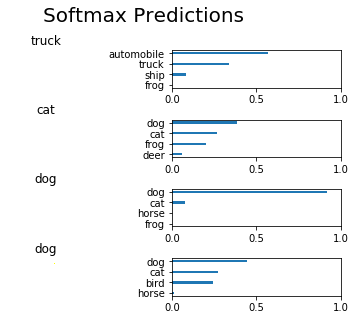

In [30]:
#Calling the function
test_classification_model()